# Assignment 2
Group Members: Mansi Nanavati, Nishanth Chidambaram, Sriraksha Rao, Anushka Sinha

This assignment is solving the tasks of symbolic, unconditioned and symbolic, conditioned generation. 

## Task 1: Symbolic Unconditioned Generation

In [1]:
import torch
import pickle
import random
import pretty_midi
import numpy as np
import seaborn as sns
import torch.nn as nn
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### JSB Chorales Dataset
For our task, we are using JSB Chorales dataset because it is easy to use and train. It is a collection of 382 four-part harmonizations composed by Johann Sebastian Bach, widely used in symbolic music modeling and generation tasks. The dataset is already preprocessed into train/validation/test splits and serialized as pickled files. For this project, we focused on the train split, which we loaded and transformed into sequences of chord tuples. We then built a vocabulary of unique chords, mapped them to integer indices, and prepared sequences for training a next-step prediction model. As part of the Exploratory Data Analysis, we are observing the number of train, test and val samples, distribution of sequence lengths in training data, unique chords, and frequency of chords. 

Number of training sequences: 229
Number of validation sequences: 76
Number of test sequences: 77
There are 4370 unique chords in training data


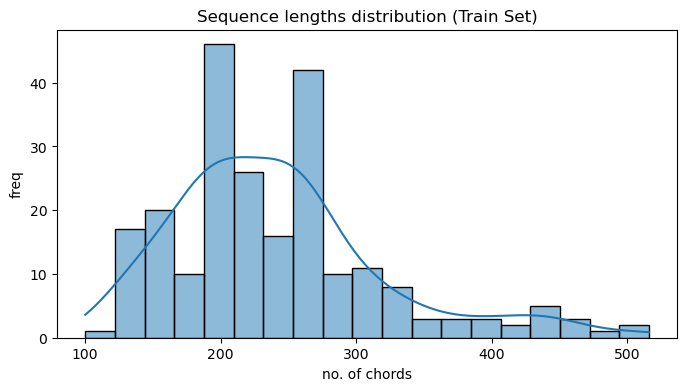

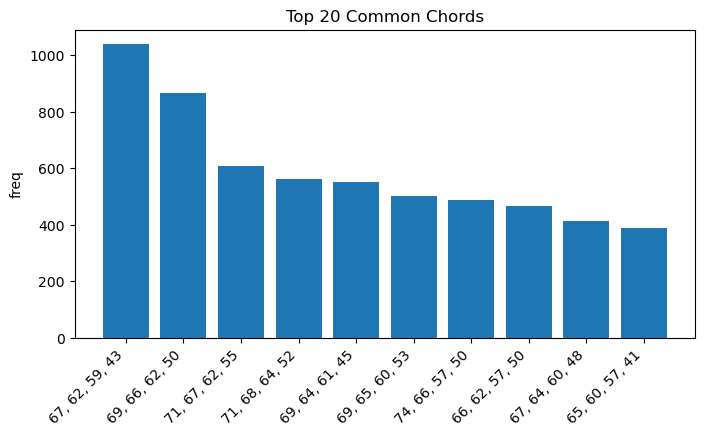

In [2]:
with open('JSB-Chorales-dataset/jsb-chorales-16th.pkl', 'rb') as p:
    data = pickle.load(p, encoding="latin1")

train_data = data['train']

print(f"Number of training sequences: {len(train_data)}")
print(f"Number of validation sequences: {len(data['valid'])}")
print(f"Number of test sequences: {len(data['test'])}")

train_lengths = [len(seq) for seq in train_data]
all_chords = [ch for sequence in train_data for ch in sequence]
unique_chords = set(all_chords)
print(f"There are {len(unique_chords)} unique chords in training data")
chord_freq = Counter(all_chords)
chords, counts = zip(*chord_freq.most_common(10))
chord_labels = [', '.join(map(str, c)) for c in chords]

plt.figure(figsize=(8, 4))
sns.histplot(train_lengths, kde=True)
plt.title("Sequence lengths distribution (Train Set)")
plt.xlabel("no. of chords")
plt.ylabel("freq")
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(chord_labels, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Common Chords")
plt.ylabel("freq")
plt.show()

We convert each entry in the dataset to tokenized sequences. We also have dictionaries chord_to_idx and idx_to_chord that help us numerically keep track of the chords. The class ChoralesDataset forms the basis of fetching items of the processed data.

In [3]:
#Dictionaries for chord to index and vice-version conversion
chord_to_idx = {chord: idx for idx, chord in enumerate(sorted(unique_chords))}
idx_to_chord = {idx: chord for chord, idx in chord_to_idx.items()}
vocab_size = len(chord_to_idx)

tokenized_sequences = [
    [chord_to_idx[chord] for chord in sequence]
    for sequence in train_data
]

sequence_length = 32
X = []
y = []

for seq in tokenized_sequences:
    if len(seq) <= sequence_length:
        continue
    for i in range(len(seq) - sequence_length):
        X.append(seq[i:i + sequence_length])
        y.append(seq[i + sequence_length])

X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)

class ChoraleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
dataset = ChoraleDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = None

### LSTM Model for generation

In this task, the goal is to generate symbolic music sequences that resemble the style and harmonic structure of the JSB Chorales dataset without conditioning on any external input. Input is a sequence of chords and output is the next chord token in the sequence. The loss function here is categorical cross-entropy between predicted and actual next chord. The objective of the model is to learn the probability distribution:
$$
p(x_1, x_2, \dots, x_T) = \prod_{t=1}^{T} p(x_t \mid x_1, x_2, \dots, x_{t-1})
$$
We explored two different types of models to achieve this task.
First option is generation with LSTM. LSTMs are good at learning temporal dependencies. They are lightweight, work well with smaller datasets and long sequences, parallelizable during training and can model long-range harmonic structures. Given the constraints of the computation (1GB GPU on Datahub), we believe that LSTM is more practical and beneficial.

In the LSTM model,
- Embedding: Converts discrete chord tokens into dense vectors
- LSTM: Processes the sequence step-by-step
- FC Layer: Outputs logits over the chord vocabulary

We are training the model for 10 epochs with a learning rate of 0.001. If the number of epochs is increased (let's say 20), the model tends to memorize a certain pattern of song which is noticeable in multiple generations, making it less "creative". When generating music of longer sequence length (>100), the LSTM model doesn't perform well (repeats the same chords) because it struggles with long-term memory.

In [ ]:
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)

        #Taking output from the last time step
        out = self.fc(out[:, -1, :])
        return out, hidden

model = LSTMGenerator(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output, _ = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 5.2715
Epoch 2/10, Loss: 3.1695
Epoch 3/10, Loss: 2.2561
Epoch 4/10, Loss: 1.7318
Epoch 5/10, Loss: 1.4044
Epoch 6/10, Loss: 1.1882
Epoch 7/10, Loss: 1.0276
Epoch 8/10, Loss: 0.8979
Epoch 9/10, Loss: 0.7994
Epoch 10/10, Loss: 0.7146


In [ ]:
def get_random_seed(vocab_size, sequence_length):
    """
    Generates random seed from vocab_size and of a specific sequence length 
    """
    return [random.randint(0, vocab_size - 1) for _ in range(sequence_length)]

def generate_sequence(seed_sequence, idx_to_chord, sequence_length=32, generate_length=64):
    """
    Generates a symbolic chord sequence using a trained LSTM model
    Input:
        seed_sequence (list of int)
        idx_to_chord (dict)
        sequence_length (int)
        generate_length (int)
    Returns:
        list of tuple
    """
    model.eval()
    generated = seed_sequence[:]
    hidden = None

    for _ in range(generate_length + sequence_length):
        # Get the last `sequence_length` tokens as input
        input_seq = generated[-sequence_length:]
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            output, hidden = model(input_tensor, hidden)
            output = output[0].cpu().numpy()
            probabilities = torch.softmax(torch.tensor(output), dim=0).numpy()
            next_token = int(np.random.choice(len(probabilities), p=probabilities))
            generated.append(next_token)

    #Removing the random seed in the start to avoid noisy output
    cleaned = generated[sequence_length:]

    #Converting to chords
    return [idx_to_chord[idx] for idx in cleaned]

def chords_to_midi(chords, filename, seconds_per_chord=0.25):
    """
    Converts a sequence of chords to MIDI file. The default program of Acoustic Grand Piano is used here for instrument.
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    start_time = 0
    for chord in chords:
        end_time = start_time + seconds_per_chord
        for pitch in chord:
            note = pretty_midi.Note(
                velocity=100, pitch=int(pitch), start=start_time, end=end_time
            )
            instrument.notes.append(note)
        start_time = end_time

    midi.instruments.append(instrument)
    midi.write(filename)
    print(f"MIDI file saved as {filename}")

In [ ]:
#Generates random seed to start off with generation
seed = get_random_seed(vocab_size, sequence_length)

generated_chords = generate_sequence(
    seed_sequence=seed,
    idx_to_chord=idx_to_chord,
    sequence_length=sequence_length,
    generate_length=100
)

filename = "symbolic_unconditioned.mid"
chords_to_midi(generated_chords, filename=filename, seconds_per_chord=0.25)

MIDI file saved as symbolic_unconditioned.mid



### Transformer Model for Generation

For this task, we also explored the use of **Transformers** for generating symbolic music sequences in the style and harmonic structure of the JSB Chorales dataset. Like the LSTM approach, the Transformer aims to model the probability distribution:

$$
p(x_1, x_2, \dots, x_T) = \prod_{t=1}^{T} p(x_t \mid x_1, x_2, \dots, x_{t-1})
$$

but does so with a different inductive bias and greater capacity for long-range dependencies.

#### Why Transformer?

Transformers have become the state-of-the-art in sequence modeling, including for symbolic music. They are powerful because:

* They use **self-attention mechanisms** to model dependencies between any pair of tokens in the sequence, regardless of distance.
* They allow for greater parallelism during training, improving efficiency on modern hardware.
* They can **capture complex, global harmonic patterns** better than RNNs or LSTMs, especially in longer sequences.

Given the relatively small dataset and limited computation resources (1GB GPU), we opt for a compact Transformer (4 layers, 256 dimensions, 8 heads) to balance **expressivity** with **efficiency**.

#### Transformer Model Architecture

* **Embedding**: Converts discrete chord tokens to dense vectors, similar to LSTM.
* **Positional Encoding**: Adds explicit information about token position, since transformers have no inherent sense of sequence order.
* **Transformer Encoder Layers**: Multiple layers of self-attention and feedforward sub-blocks capture dependencies and compositional structure across the whole sequence.
* **Output Layer**: Fully connected layer to predict logits over the vocabulary of possible chord tokens at each time step.

#### Training and Generation

* We train the model for 10 epochs using Adam optimizer and cross-entropy loss, mapping each chord token to the next in the sequence (next-token prediction).
* **Longer training** (e.g., 20+ epochs) can lead to overfitting, with the model memorizing common patterns and losing generative creativity.
* For generation, the model autoregressively predicts each next token, conditioned on all previous outputs. We use temperature sampling to control randomness.

#### Limitations and Behavior

* **Transformers** are generally better at maintaining musical coherence over longer sequences than LSTMs, thanks to self-attention.
* With very long sequences or limited data, Transformers can still exhibit repetition or lose global structure, but typically outperform LSTMs on long-range dependencies.
* The model's creativity can be modulated with temperature and maximum sequence length during generation.

In [ ]:
import os
import json
import pickle
import miditok
import miditoolkit
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [ ]:
# ===== STEP 1: Tokenize JSB Chorales =====

token_folder = 'jsb_tokens'
os.makedirs(token_folder, exist_ok=True)
tokenizer = miditok.REMI()

def array_to_midi(array, tpq=480):
    midi = miditoolkit.MidiFile(ticks_per_beat=tpq)
    inst = miditoolkit.Instrument(0, is_drum=False)
    for t, notes in enumerate(array):
        for pitch in notes:
            start = int(t * tpq // 4)
            end = int((t + 1) * tpq // 4)
            inst.notes.append(miditoolkit.Note(
                velocity=64, pitch=int(pitch), start=start, end=end
            ))
    midi.instruments.append(inst)
    return midi

# ---- Load Pickle File ----
with open('JSB-Chorales-dataset/jsb-chorales-16th.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # use encoding if needed

tpq = 480
chorale_tempos = []

# ---- Tokenize and Save Each Chorale ----
for idx, seq in enumerate(data['train']):
    midi = array_to_midi(seq, tpq=tpq)
    tokens = tokenizer(midi)
    if hasattr(tokens, "ids"):
        token_ids = tokens.ids
    elif isinstance(tokens, list) and len(tokens) > 0 and hasattr(tokens[0], "ids"):
        # flatten list of TokSequences
        token_ids = [tid for t in tokens for tid in t.ids]
    else:
        token_ids = tokens  # fallback
    chorale_tempos.append(120)  # JSB is 120 BPM by default
    with open(os.path.join(token_folder, f"chorale_{idx}.json"), "w") as fp:
        json.dump({'ids': token_ids}, fp)

tokenizer.save_params(token_folder)

avg_bpm = sum(chorale_tempos) / len(chorale_tempos) if chorale_tempos else 120
avg_us_per_quarter = 60_000_000 / avg_bpm
print(f"Chorale average BPM: {avg_bpm:.2f}, us/quarter: {avg_us_per_quarter:.2f}")

In [ ]:
# ===== STEP 2: PyTorch Dataset and Loader =====

class MIDITokenDataset(Dataset):
    def __init__(self, token_folder):
        self.files = [
            os.path.join(token_folder, f)
            for f in os.listdir(token_folder)
            if f.endswith(".json") and f != "tokenizer.json" and f.lower().startswith("chorale")
        ]
        param_path = os.path.join(token_folder, "tokenizer.json")
        self.tokenizer = miditok.REMI(params=param_path)
        self.sequences = []
        for file in self.files:
            with open(file, "r") as fp:
                tok_seq = json.load(fp)
            if 'ids' in tok_seq and len(tok_seq['ids']) > 1:
                self.sequences.append(tok_seq['ids'])
            else:
                print(f"Skipping {file} (empty or missing 'ids')")
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        x = torch.tensor(seq[:-1], dtype=torch.long)
        y = torch.tensor(seq[1:], dtype=torch.long)
        return x, y

dataset = MIDITokenDataset(token_folder)
from torch.nn.utils.rnn import pad_sequence

def collate_pad(batch):
    xs, ys = zip(*batch)
    xs_padded = pad_sequence(xs, batch_first=True, padding_value=0)
    ys_padded = pad_sequence(ys, batch_first=True, padding_value=0)
    return xs_padded, ys_padded

loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True, collate_fn=collate_pad)

In [ ]:
# ===== STEP 3: Transformer Model =====

def get_positional_encoding(seq_len, d_model, device):
    position = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe = torch.zeros(seq_len, d_model, device=device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class MusicTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=1024,
        dropout=0.1,
    ):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        batch_size, seq_len = x.shape
        pos_enc = get_positional_encoding(seq_len, self.embed.embedding_dim, x.device).unsqueeze(0)
        x = self.embed(x) + pos_enc
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)
        return self.fc_out(x)

vocab_size = len(dataset.tokenizer.vocab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MusicTransformer(vocab_size).to(device)

In [ ]:
# ===== STEP 4: Training Loop =====

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out.view(-1, out.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}")

In [ ]:
# ===== STEP 5: Generation =====

def generate_until_duration_smart(
    model, tokenizer, device, target_seconds=25, temperature=1.0, max_tokens=3000,
    tpq=480, tempo_us_per_quarter=500_000, max_tokens_per_beat=4
):
    model.eval()
    start_token = list(tokenizer.vocab.values())[0]
    seq = [start_token]
    x = torch.tensor([seq], dtype=torch.long).to(device)
    elapsed_seconds = 0
    tokens_in_current_beat = 0

    time_shift_token_ids = [
        tid for t, tid in tokenizer.vocab.items() if t.lower().startswith("timeshift")
    ]

    while elapsed_seconds < target_seconds and len(seq) < max_tokens:
        with torch.no_grad():
            logits = model(x)
            logits = logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
        if next_token in time_shift_token_ids:
            tokens_in_current_beat = 0
        else:
            tokens_in_current_beat += 1
        if tokens_in_current_beat > max_tokens_per_beat:
            tokens_in_current_beat = 0  # You could forcibly insert a TimeShift here
        seq.append(next_token)
        x = torch.tensor([seq], dtype=torch.long).to(device)
        if len(seq) % 32 == 0 or elapsed_seconds == 0:
            midi_obj = tokenizer.tokens_to_midi([seq])
            ticks = midi_obj.end()
            elapsed_seconds = ticks / tpq * (tempo_us_per_quarter / 1_000_000)
    return seq

tokens = generate_until_duration_smart(
    model,
    dataset.tokenizer,
    device=device,
    target_seconds=25,
    temperature=1.0,
    max_tokens=3000,
    tpq=480,
    tempo_us_per_quarter=avg_us_per_quarter,
    max_tokens_per_beat=4
)

midi = dataset.tokenizer.tokens_to_midi([tokens])
midi.dump_midi("generated_chorale_jsb.mid")
print("Saved generated_chorale_jsb.mid")


### Transformer vs LSTM for Symbolic Music Generation

|                                      | **LSTM**                                                                                                                                              | **Transformer**                                                                                                                         |
| ------------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **Long-range dependencies**          | Moderate: Good at modeling short to mid-range dependencies, but struggles with very long sequences due to vanishing gradients and memory bottlenecks. | Excellent: Self-attention enables direct modeling of all token relationships, capturing both local and global dependencies effectively. |
| **Parallelism**                      | Limited: Processes tokens sequentially during training and inference; less efficient on modern hardware.                                              | High: Enables parallel computation across entire sequences (during training), utilizing hardware efficiently.                           |
| **Parameter efficiency**             | Efficient for small data: Fewer parameters, easier to train with limited data.                                                                        | Often requires more parameters for similar capacity; can be overkill or prone to overfitting on small datasets.                         |
| **Training speed**                   | Slower due to sequential nature, especially for long sequences.                                                                                       | Faster (per epoch) since training is parallelized, but each epoch may take more memory.                                                 |
| **Memory usage**                     | Low to moderate; scales linearly with sequence length.                                                                                                | High; scales quadratically with sequence length (attention computation).                                                                |
| **Overfitting risk**                 | Lower: Simpler, less prone to memorizing limited training data.                                                                                       | Higher: More capacity to memorize training data; regularization is crucial.                                                             |
| **Handling repetition / creativity** | Tends to repeat patterns in longer generations; struggles to sustain creative variation.                                                              | Handles longer coherent generations better, but can also repeat if overfit or with poor sampling.                                       |
| **Interpretability**                 | Less interpretable (hidden state dynamics are hard to analyze).                                                                                       | Attention weights allow inspection of what the model is focusing on at each step.                                                       |
| **Applicability to JSB Chorales**    | Works well for the dataset size and moderate-length pieces; efficient on limited GPU.                                                                 | Can leverage richer relationships, but risk of overfitting; needs careful tuning for small datasets and limited compute.                |
| **Overall Strengths**                | - Good for small datasets<br>- Low compute<br>- Handles moderate sequences<br>- Less prone to overfit                                                 | - Captures long-range structure<br>- Parallel training<br>- Attention is interpretable<br>- Often better on complex dependencies        |
| **Overall Weaknesses**               | - Limited memory for long-range<br>- Slow for long sequences<br>- Harder to parallelize                                                               | - Higher memory/compute needs<br>- Can overfit with limited data<br>- More hyperparameters                                              |

---

**In practice for JSB Chorales:**

* **LSTM** is easier to train and less prone to overfitting, making it practical for limited data and compute.
* **Transformer** can generate richer, longer, and more globally coherent music, but requires careful regularization and can overfit quickly on small datasets.